# Skrót wiedzy z uczenia maszynowego

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (8,6)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

# Czym jest uczenie maszynowe?

## Podział na uczenie z nadzorem i bez nadzoru (supervised vs unsupervised)

![](https://devopedia.org/images/article/386/2437.1641922762.jpg)
[źródło](https://devopedia.org/)

## Semi supervised learning

![semi-supervised-learning](https://jhui.github.io/assets/ml/ssl.png)
[źródło](https://jhui.github.io/2017/01/15/Machine-learning-nonsupervised-and-semi-supervised-learning/)

# Rozpoczęcie modelowania
## Prosty model  

Stwórzmy prosty problem regresyjny

In [62]:
df = make_regression(n_samples=100, n_features=1, random_state=420, bias = 10, noise = 10)
X = df[0].flatten()
y = df[1]

Jak wygląda zależność w naszych danych?

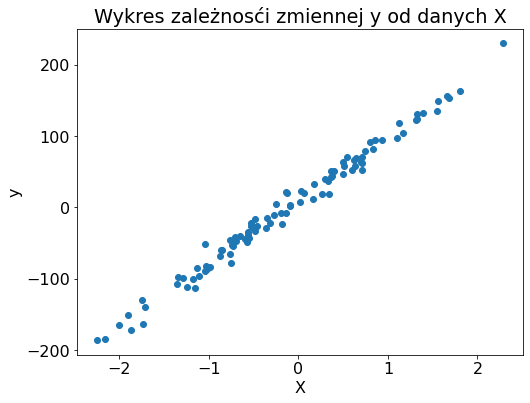

In [63]:
plt.scatter(X, y)
plt.title("Wykres zależnosći zmiennej y od danych X")
plt.ylabel("y")
plt.xlabel("X")
plt.show()

W tym przypadku dobry model da się zapisać jako funkcje

In [59]:
model = lambda x, coef: x*coef 

Sprawdźmy jakie wartości przewiduje model dla danych X

In [64]:
pred = model(X, 100)

Zmierzmy różnicę z znanym, prawdziwym `y`

In [65]:
some_error = np.sqrt(np.mean(np.sum((pred - y)**2)))
some_error

194.19267996192215

In [66]:
np.mean(np.abs((y-pred)))/np.mean(np.abs(y))

0.22700428489647795

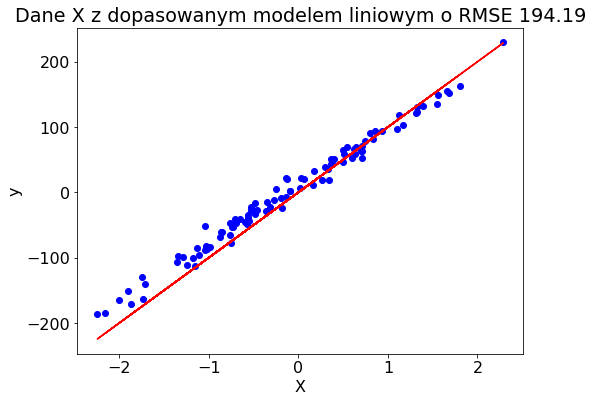

In [67]:
plt.scatter(X, y,c = "blue")
plt.plot(X, pred,c = "red")
plt.title(f"Dane X z dopasowanym modelem liniowym o RMSE {some_error:.2f}")
plt.ylabel("y")
plt.xlabel("X")
plt.show()

## Ale jak znajdować współczynniki, czyli ogólnie jak budować modele?
By odpowiedzieć na to pytanie musimy się cofnąć do danych

# Przygotowanie danych
W jego skład wchodzą następujące kroki
- ### Rozwiązanie problemu braków i nieprawidłowych danych
- ### Skalowanie (standaryzacja, min-max itp)
- ### Kodowanie zmiennych kategorycznych (one hot i inne)
- ### Usunięcie współliniowości

wczytajmy nowy zbiór danych posiadający ciekawe, wybrakowane dane

In [9]:
titanic = pd.read_csv("titanic.csv")

In [10]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [11]:
titanic.to_csv("titanic.csv", index=False)

In [12]:
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


- ## Rozwiązanie problemu braków i nieprawidłowych danych
kilka użytecznych przykładów w [dokumentacja](https://scikit-learn.org/stable/modules/impute.html#impute) `sklearn`

Mamy braki danyhc w kolumnach 
- liczbowych: Age i Fare
- kategorycznych: Cabin, Embarked

W przypadku gdy mamy dużo brakujących danych w wierszu, badź kolumnie, można je usunąć.
Tak się naprzykład stanie z kolumną Cabin

In [13]:
titanic = titanic.drop('Cabin', axis = 1)

### Uzupełnianie pozostałych informacji

**Age** - średnia

In [14]:
titanic['Age'].mean()

29.881137667304014

In [15]:
titanic.loc[titanic['Age'].isna(),'Age'] = titanic['Age'].mean()

**Fare** - mediana

In [16]:
titanic['Fare'].median()

14.4542

In [17]:
titanic.loc[titanic['Fare'].isna(),'Fare'] = titanic['Fare'].median()

**Embarked** - dominanta (moda)

In [18]:
titanic['Embarked'].mode().iloc[0]

'S'

In [19]:
titanic.loc[titanic['Embarked'].isna(),'Embarked'] = titanic['Embarked'].mode().iloc[0]

- ## Odzyskiwanie informacji z złożonych kolumn
Na przykładzie kolumny Name

Moglibyśmhy wyciągnąć np zwroty grzecznościowe z imion, dla prostoty natomiast wyciągniemy długość imienia jako liczbę znaków

In [20]:
titanic['name_lenght'] = titanic['Name'].str.len()

- ## Odrzucamy nieistotne kolumny
To kolumny takie jak id oraz kolumny, które przez typ danych nie mogą zostać użyte do uczenia

In [21]:
titanic = titanic.drop(["PassengerId","Name","Ticket"], axis=1)

- ## Skalowanie (standaryzacja, min-max itp)
[artykuł](https://rahul-saini.medium.com/feature-scaling-why-it-is-required-8a93df1af310) tłumaczący potrzebe skalowania lub jej brak z przykładami

In [22]:
for col in ['Fare','Age','name_lenght']:
    transf = titanic[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    titanic[col] = scaler.transform(transf)

In [23]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_lenght
0,0,3,male,-0.611972,1,0,-0.503291,S,-0.434672
1,1,1,female,0.630431,1,0,0.734744,C,2.511806
2,1,3,female,-0.301371,0,0,-0.490240,S,-0.539904
3,1,1,female,0.397481,1,0,0.383183,S,1.775186
4,0,3,male,0.397481,0,0,-0.487824,S,-0.329441


- ## Kodowanie zmiennych kategorycznych (one hot i inne)
[artykuł](https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/) o różnych kodowaniachx, my wykorzystamy one-hot oraz funkcję z pakietu pandas

Kolumnę Sex wystarczy zamienić na liczbę 

In [24]:
titanic['Sex'] = (titanic['Sex'] == 'female')*1

Pozostałe chcemy zakodowac używając, ale **nie tworząć współliniowości!!**

In [25]:
encoded = pd.get_dummies(titanic[["Pclass","Embarked"]].astype(str))
encoded.head()

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,0,0,1
1,1,0,0,1,0,0
2,0,0,1,0,0,1
3,1,0,0,0,0,1
4,0,0,1,0,0,1


Usunięcie kolumn "Pclass_1","Embarked_C", oznacza, że nasz model domyślnie będzie robił predykcję dla tych klas

In [26]:
encoded = encoded.drop(["Pclass_1","Embarked_C"], axis = 1)
titanic = titanic.drop(["Pclass","Embarked"], axis=1)
titanic = pd.concat([titanic, encoded], axis = 1)

In [27]:
titanic.head()

,Survived,Sex,Age,SibSp,Parch,Fare,name_lenght,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,0,-0.611972,1,0,-0.503291,-0.434672,0,1,0,1
1,1,1,0.630431,1,0,0.734744,2.511806,0,0,0,0
2,1,1,-0.301371,0,0,-0.490240,-0.539904,0,1,0,1
3,1,1,0.397481,1,0,0.383183,1.775186,0,0,0,1
4,0,0,0.397481,0,0,-0.487824,-0.329441,0,1,0,1


- ## Usunięcie współliniowości
[artykuł](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4318006/) opisujący kilka przypadków współliniowości

<AxesSubplot:>

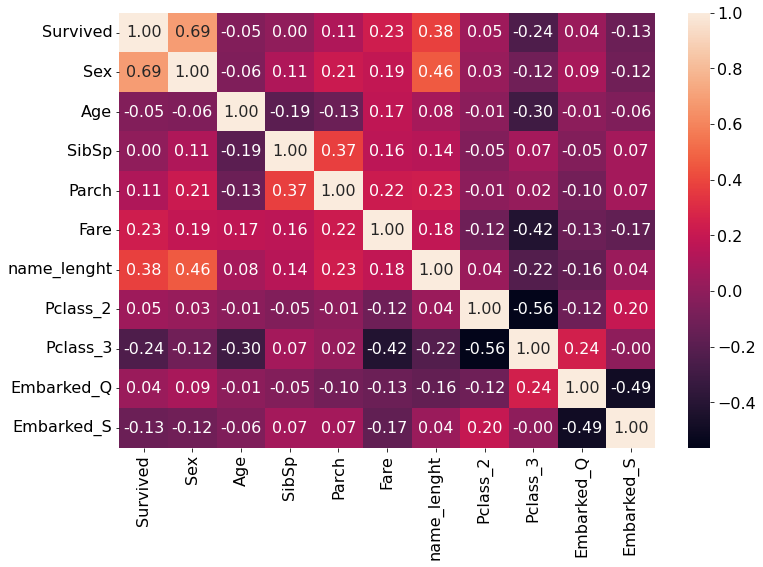

In [28]:
plt.figure(figsize=(12,8))
corr = titanic.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt=".2f")

Płeć jest najmocniej skorelowana z przeżyciem, ale na tyle mocno by usuwać tą kolumnę. Moglibyśmy to rozważać gdyby współliniowość wynosiła ponad 0.9






- ## Pipeline `sklearn`
Przydatnym narzędziem do łączenia powyższych operacji może być [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) z pakietu `sklearn`. Pozwalają one przygotować całą ścieżkę przekształacania danych, która może być potem łątwo wielokrotnie wykorzystana


In [29]:
y = titanic['Survived']
X = titanic.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [30]:
pipe.score(X_test, y_test)

0.8932926829268293


# Powrót do wina
Powrót do danych o winie `winequality-red.csv`

In [31]:
wine = pd.read_csv("../lab2/winequality-red.csv", sep =';')

In [32]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



# Spojrzenie na dane
Powrót do danych o winie `winequality-red.csv`
## Jaki problem mamy?

In [33]:
wine = pd.read_csv("../lab2/winequality-red.csv", sep =';')

In [34]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


podzielmy na szybko nasze dane na uczące i kolumnę celu

In [35]:
y = wine['quality']
X = wine.drop('quality', axis = 1)

Oraz podzielmy na szybko zbiór danych na część treningową i testową

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

Wybieram, że będe rozwiązywał problem klasyfikacji. Załaduje więc model RandomForest, spokojnie będzie on szczegółowo wytłumaczony w przyszłości. Na razie można go traktować jako dowolny model klasyfikacji. W modelu RandomFores uczenie nie jest deterministyczne, a wiec ustawiam ziarno losowości

In [37]:
rf = RandomForestClassifier(random_state=123)

'Uczę' czyli dopasowuje model do danych

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

# Dzielenie zbioru na podzbiory train/test/validation


- ## Problem przecieku informacji

Zbiór testowy poninien jak najlepiej symulować nowe dane, z którymi model nie miał wcześniej kontaktu.


#### Poważny przeciek informacji mamy w momencie:
- informacje inne niż te z zbioru treningowego były wykorzystane do tworzenia modelu
- wielokrotnej oceny skuteczności modelu wykorzystującej dane testowe




- ## Jak duży zbiór testowy wybrać
Co źródło, to inna informcja. Domyślnie często dane testowe to 1/3 wszystkich dostępnych, ale branie 1/5 również nie powinno powodować strat w generalizacji. Czasami możemy zejść poniżej 20%, ale takie przypadki powinny być uzasadnione np.   



- ## Kroswalidacja i problem zbalansowania klas
Szczegółowy opis posiada znowu [dokumentacja](https://scikit-learn.org/stable/modules/cross_validation.html#) `sklearn`
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">
źródło: https://scikit-learn.org/

In [39]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.70394737, 0.67105263, 0.72039474, 0.70723684, 0.71617162])

- ## Wykorzystanie zbioru walidacyjnego

### KFold 
Nie bierze pod uwagę równomiernego rozłożenia klas

In [40]:
kf = KFold(n_splits=5)
for train, test in kf.split(X, y):
    print(f'train -  {np.bincount(y[train])}   |   test -  {np.bincount(y[test])}')

train -  [  0   0   0  10  38 501 537 177  16]   |   test -  [  0   0   0   0  15 180 101  22   2]
train -  [  0   0   0   8  48 564 495 153  11]   |   test -  [  0   0   0   2   5 117 143  46   7]
train -  [  0   0   0   7  41 527 534 153  17]   |   test -  [  0   0   0   3  12 154 104  46   1]
train -  [  0   0   0  10  43 594 484 135  13]   |   test -  [  0   0   0   0  10  87 154  64   5]
train -  [  0   0   0   5  42 538 502 178  15]   |   test -  [  0   0   0   5  11 143 136  21   3]


### StratifiedKFold 
Próbuje równo rozłożyć klasy

In [41]:
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, y):
    print(f'train -  {np.bincount(y[train])}   |   test -  {np.bincount(y[test])}')
    
# kf = KFold(n_splits=3)
# for train, test in kf.split(X, y):

train -  [  0   0   0   8  42 544 511 159  15]   |   test -  [  0   0   0   2  11 137 127  40   3]
train -  [  0   0   0   8  43 545 510 159  14]   |   test -  [  0   0   0   2  10 136 128  40   4]
train -  [  0   0   0   8  43 545 510 159  14]   |   test -  [  0   0   0   2  10 136 128  40   4]
train -  [  0   0   0   8  42 545 510 160  14]   |   test -  [  0   0   0   2  11 136 128  39   4]
train -  [  0   0   0   8  42 545 511 159  15]   |   test -  [  0   0   0   2  11 136 127  40   3]


Rysunkowy przykład działania StratifiedKFold 
![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_009.png)
źródło: https://scikit-learn.org/

# Mierzenie skuteczności modelu
Spis [wszystkich metryk](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) w sklearn. Czy to oznacza, że są to jedyne, które warto rozważać?

In [42]:
## Predykcja klasy wina
y_pred = rf.predict(X_test)

In [43]:
y_pred[:5]

array([5, 5, 5, 5, 6], dtype=int64)

In [44]:
y_pred_proba = rf.predict_proba(X_test)

In [45]:
y_pred_proba[:5,:]

array([[0.  , 0.01, 0.75, 0.23, 0.01, 0.  ],
       [0.  , 0.06, 0.69, 0.24, 0.01, 0.  ],
       [0.01, 0.05, 0.55, 0.34, 0.05, 0.  ],
       [0.01, 0.04, 0.59, 0.33, 0.03, 0.  ],
       [0.  , 0.  , 0.01, 0.98, 0.01, 0.  ]])

Random forest posiada wpudowanę metrykę skuteczności

In [46]:
rf.score(X_test, y_test)

0.6375

I jest to accuracy

In [47]:
accuracy_score(y_pred, y_test)

0.6375

Natomiast w prawie przystkich przypadkach należy unikać metryki accuracy, są zdecydowanie lepsze metryki takie jak dwie poniższe (dla przypadku klasyfikacji multiklasowej wymagały dodatkowych parametrów)

In [48]:
f1_score(y_test, y_pred, average='micro')

0.6375

In [49]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.7816760229298114

# Strojenie modelu (Hyperparameter tuning)
Tak jak prawie zawsze. [Link](https://scikit-learn.org/stable/modules/grid_search.html) do dokumentacji sklearn


lista wszystkich hiperparametrów modelu Random Forest. Nie wszystkie rzeczywiście chcemy sprawdzać

In [50]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

zdefiniujmy przestrzeń poszukiwań

In [51]:
search_space = {'n_estimators': np.arange(1,100,5), 'max_depth': [5,10]}

Stwórzymy nowy model, który będziemy dostrajać

In [52]:
rf = RandomForestClassifier(n_jobs=-1, random_state=420)

Stwórzmy obiekt klasy `GridSearchCV`, któremu podajemy przestrzeń poszukiwań

In [53]:
clf = GridSearchCV(rf, search_space, verbose = 2)

Proces szukania, również uruchamia się metodą `.fit()`

In [54]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ........................max_depth=5, n_estimators=1; total time=   1.8s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.0s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.0s
[CV] END .......................max_depth=5, n_

[CV] END ......................max_depth=10, n_estimators=11; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=11; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=11; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=16; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=16; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=16; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=16; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=16; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=21; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=21; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=21; total time=   0.0s
[CV] END ......................max_depth=10, n_estimators=21; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=420),
             param_grid={'max_depth': [5, 10],
                         'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             verbose=2)

Możemy wyświetlić np. tylko najlpesze paramtery

In [55]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 36}

Lub przeanalizować wyniki wszystkich strojeń modelu

In [56]:
results = pd.DataFrame(clf.cv_results_)
results = pd.concat([results['params'].apply(pd.Series), results[['mean_test_score']]], axis=1)

In [57]:
results.head()

,max_depth,n_estimators,mean_test_score
0,5,1,0.562858
1,5,6,0.606336
2,5,11,0.621498
3,5,16,0.618206
4,5,21,0.618866


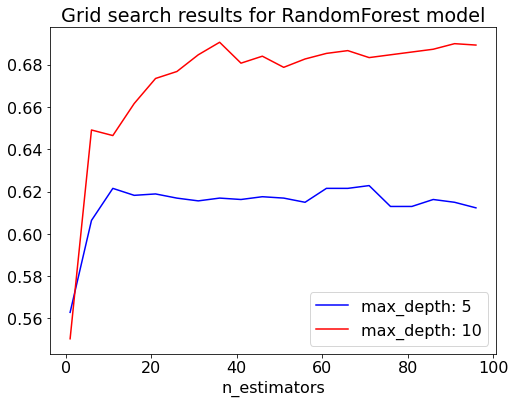

In [58]:
fig, ax = plt.subplots()
grouped = results.groupby('max_depth')
colors = {5:"blue",10:"red"}
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='n_estimators', y='mean_test_score', label=f"max_depth: {key}", color=colors[key])
plt.title("Grid search results for RandomForest model")
plt.show()

# Potencjalne problemy, o których warto pamiętać
-  <h3>Błędy w danych</h3> - jak chcemy je obsłużyć
- <h3> Niezbalansowanie klas </h3> - czy nasze rozwiązanie jest odporne na nieznbalansowanie klas?
- <h3> Data leakage</h3> - czy przy tworzeniu modelu nie wykorzystujemy danych testowych?
- <h3> Overfitting i underfitting</h3> - czy nasz model się dobrze generalizuje?